# 12.5 softmax回归建模实验

接下来，继续上一节内容，我们进行softmax回归建模实验

* 导入相关的包

In [10]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchLearning import *

from torch.utils.tensorboard import SummaryWriter

# 一个cell输出多个结果
writer = SummaryWriter(log_dir= 'reg_loss')


## 12.5.1 softmax回归手动实现

据此前的介绍，面对分类问题，更为通用的处理办法是将其转为哑变量的形式，然后使用softmax回归进行处理，这种处理方式同样适用于二分类或者多分类问题，此处以多分类问题为例，介绍softmax的手动实现形式。

---


[补充]： softmax的另一种理解角度：

我们都知道，softmax是挑选最大值的一种方法，通过以下公式对不同类的计算结果进行数值上的转化：

$$
\text{Softmax}(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{N} e^{z_j}}
$$

其中，$N$ 是输入向量 $z$ 的维度（元素个数），$e$ 是自然对数的底数（约等于2.71828）。

这种转化可以将结果放缩到 0-1 之间，并且使用 softmax 进行最大值的比较，相比 max，能有效避免损失函数求解时再0点不可导的问题，损失函数的函数特性，将是后续我们选择优化算法的关键，具体我们可以通过下述图像进行比较。

-10 0
-9 0
-8 0
-7 0
-6 0
-5 0
-4 0
-3 0
-2 0
-1 0
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


Text(0.5, 1.0, 'Max Function')

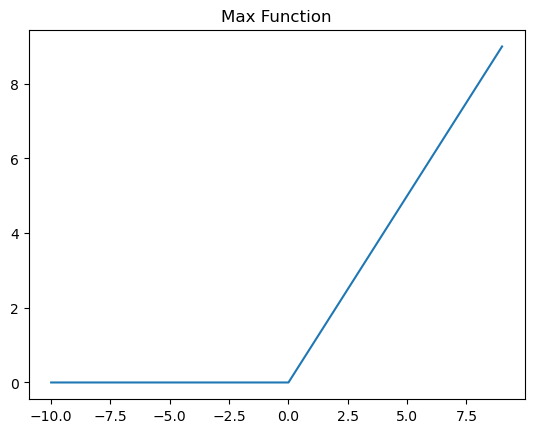

In [11]:
from matplotlib import pyplot

def max_x(x, delta= 0.):
    x = np.array(x)
    negative_idx = x < delta
    x[negative_idx] = 0.
    return x
x = np.array(range(-10, 10))
s_j = np.array(x)

hinge_loss = max_x(s_j, delta= 1.)
for i in range(0, 20):
    print(s_j[i], hinge_loss[i])
pyplot.plot(s_j, hinge_loss)
pyplot.title('Max Function')


In [12]:
x = np.array([1, 2, 3])
id = x <= 2
id


array([ True,  True, False])

In [13]:
y = np.array([2, 3, 4])
y[id]

array([2, 3])

    布尔数组可以用作索引是因为它们可以被解释为表示元素的选择或过滤条件。当使用布尔数组作为索引时，只有对应位置为 True 的元素会被选择或操作，而对应位置为 False 的元素会被忽略

Text(0.5, 1.0, 'softmax vs max')

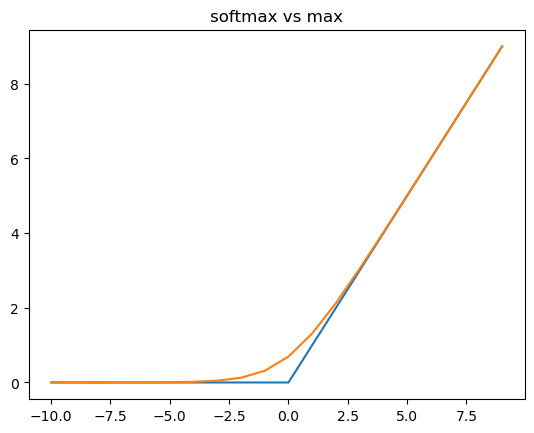

In [14]:
def cross_entropy_test(s_k, s_j):
    soft_max = 1/(1 + np.exp(s_k - s_j))
    cross_entropy_loss = -np.log(soft_max)
    return cross_entropy_loss
s_i = 0
s_k = np.array(range(-10, 10))

soft_x = cross_entropy_test(s_k, s_i)

pyplot.plot(s_j, hinge_loss)
pyplot.plot(range(-10, 10), soft_x)
pyplot.title('softmax vs max')

---

1. 生成数据集

利用此前的数据生成函数，创建一个三分类，且内部离散程度不是很高的分类数据集

In [15]:
tensorGenCla?

Signature:
tensorGenCla(
    num_examples=500,
    num_inputs=2,
    num_class=3,
    deg_dispersion=[4, 2],
    bias=False,
)
Docstring:
分类数据集创建函数
num_examples: 每个类别的数据数量
num_inputs: 数据集特征数量
num_class: 数据集标签类别总数
deg_dispersion: 数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考，第二个参数表示随机数组标准差。
bias: 建立模型逻辑回归模型时是否带入截距
return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组
File:      /media/liu/HP USB321FD/DL学习/Python工具包学习/Nerual_network_train/torchLearning.py
Type:      function

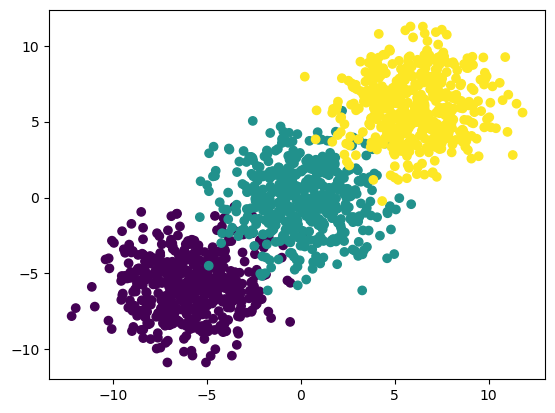

In [16]:
# 设置随机数种子
torch.manual_seed(420)

features, labels = tensorGenCla(bias= True, deg_dispersion= [6, 2])
plt.scatter(features[:, 0], features[:, 1], c= labels)

In [17]:
features

tensor([[-6.0141, -4.9911,  1.0000],
        [-4.6593, -6.7657,  1.0000],
        [-5.9395, -5.2347,  1.0000],
        ...,
        [ 6.4622,  4.1406,  1.0000],
        [ 5.7278,  9.2208,  1.0000],
        [ 4.9705,  3.1236,  1.0000]])

In [18]:
labels.unique()

tensor([0, 1, 2])

2. 建模流程

* Stage 1.模型选择

围绕建模目标，我们可以构建一个只包含一层的神经网络进行建模

![Alt text](image-28.png)

根据此前课程的介绍，输出层的每个神经元输出结果都代表某条样本再三个类别中 softmax后的取值，此时神经网络拥有一层，且是全连接。此时从特征到输出结果，就不再是简单的线性方程变换，而是矩阵相乘之后进行softmax转化。

In [19]:
def softmax(x, w):
    m = torch.exp(torch.mm(x, w))
    sp = torch.sum(m, 1).reshape(-1, 1)
    return m / sp


此处X是特征张量，W是由两层之间的连接权重所组成的矩阵，且W的行数就是输入数据特征的数量，W的列数就是输出层的神经元个数，或者说就是分类问题的类别总数。计算过程我们可以通过下述例子进行说明：

In [20]:
f = features[: 10]
f

tensor([[-6.0141, -4.9911,  1.0000],
        [-4.6593, -6.7657,  1.0000],
        [-5.9395, -5.2347,  1.0000],
        [-7.0262, -4.5792,  1.0000],
        [-2.3817, -5.1295,  1.0000],
        [-0.7093, -5.4693,  1.0000],
        [-4.1530, -6.8751,  1.0000],
        [-1.9636, -3.3003,  1.0000],
        [-6.5046, -6.0710,  1.0000],
        [-6.1291, -7.1835,  1.0000]])

In [21]:
l = labels[:10]
l

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

In [22]:
w = torch.arange(9).reshape(3, 3).float()
w

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [23]:
m1 = torch.mm(f, w)
m1

tensor([[ -8.9733, -18.9785, -28.9837],
        [-14.2971, -24.7221, -35.1471],
        [ -9.7042, -19.8785, -30.0527],
        [ -7.7375, -18.3429, -28.9483],
        [ -9.3886, -15.8998, -22.4111],
        [-10.4079, -15.5865, -20.7651],
        [-14.6253, -24.6535, -34.6816],
        [ -3.9010,  -8.1649, -12.4289],
        [-12.2130, -23.7886, -35.3642],
        [-15.5506, -27.8632, -40.1758]])

此时，上述矩阵的每一行都代表每一条数据在三个类别上的线性方程计算结果，然后需要进行softmax转化

In [24]:
torch.sum(w, 1)

tensor([ 3., 12., 21.])

In [25]:
torch.sum(torch.exp(m1), 1)

tensor([1.2675e-04, 6.1779e-07, 6.1028e-05, 4.3619e-04, 8.3794e-05, 3.0364e-05,
        4.4495e-07, 2.0511e-02, 4.9655e-06, 1.7639e-07])

In [26]:
torch.exp(m1) / torch.sum(torch.exp(m1), 1).reshape(-1, 1)

tensor([[9.9995e-01, 4.5163e-05, 2.0398e-09],
        [9.9997e-01, 2.9681e-05, 8.8098e-10],
        [9.9996e-01, 3.8138e-05, 1.4546e-09],
        [9.9998e-01, 2.4781e-05, 6.1412e-10],
        [9.9851e-01, 1.4845e-03, 2.2070e-06],
        [9.9436e-01, 5.6040e-03, 3.1583e-05],
        [9.9996e-01, 4.4139e-05, 1.9484e-09],
        [9.8594e-01, 1.3869e-02, 1.9509e-04],
        [9.9999e-01, 9.3923e-06, 8.8216e-11],
        [1.0000e+00, 4.4946e-06, 2.0202e-11]])

上述结果的每一行就是经过softmax转化之后每一条数据再三个不同类别上的取值。该函数和 nn.functional 中 softmax函数功能一致。只不过需要注意的是，我们定义的softmax函数需要输入原始数据和系数矩阵，而 F.softmax只需要输入输出节点中经过线性运算的结果及 softmax的方向（按行还是按列）

In [27]:
softmax(f, w)

tensor([[9.9995e-01, 4.5163e-05, 2.0398e-09],
        [9.9997e-01, 2.9681e-05, 8.8098e-10],
        [9.9996e-01, 3.8138e-05, 1.4546e-09],
        [9.9998e-01, 2.4781e-05, 6.1412e-10],
        [9.9851e-01, 1.4845e-03, 2.2070e-06],
        [9.9436e-01, 5.6040e-03, 3.1583e-05],
        [9.9996e-01, 4.4139e-05, 1.9484e-09],
        [9.8594e-01, 1.3869e-02, 1.9509e-04],
        [9.9999e-01, 9.3923e-06, 8.8216e-11],
        [1.0000e+00, 4.4946e-06, 2.0202e-11]])

In [28]:
F.softmax(m1, 1)

tensor([[9.9995e-01, 4.5163e-05, 2.0398e-09],
        [9.9997e-01, 2.9681e-05, 8.8098e-10],
        [9.9996e-01, 3.8138e-05, 1.4546e-09],
        [9.9998e-01, 2.4781e-05, 6.1412e-10],
        [9.9851e-01, 1.4845e-03, 2.2069e-06],
        [9.9436e-01, 5.6040e-03, 3.1583e-05],
        [9.9996e-01, 4.4139e-05, 1.9484e-09],
        [9.8594e-01, 1.3869e-02, 1.9509e-04],
        [9.9999e-01, 9.3923e-06, 8.8216e-11],
        [1.0000e+00, 4.4946e-06, 2.0202e-11]])

* Stage 2.确定目标函数

此时目标函数就是交叉熵损失函数。由于标签已经经过了哑变量转化，因此交叉熵的主体就是每条数据的真实类别对应概率的累乘结果。作为多分类问题的最通用的损失函数，我们有必要简单回顾交叉熵的计算过程：

In [29]:
f = torch.tensor([[0.6, 0.2, 0.2], [0.3, 0.4, 0.3]])
l = torch.tensor([0, 1])

f

tensor([[0.6000, 0.2000, 0.2000],
        [0.3000, 0.4000, 0.3000]])

In [30]:
l

tensor([0, 1])

其中 f 代表两条数据再三个类别上通过 softmax 输出的比例结果，l 代表这两条数据的真实标签，我们可以将这两条数据再不同类别上的概率取值看成是随机变量，而这两个随机变量再真实类别上的联合概率分布的具体取值则是 $ 0.6*0.4 $ ，进一步，交叉熵损失函数 = -log(所有数据再真实类别上的联合概率分布)/数据总量，据此我们可以定义交叉熵损失函数如下：

In [31]:
def m_cross_entropy(soft_z, y):
    y = y.long()
    prob_real = torch.gather(soft_z, 1, y)
    return (-(1/y.numel()) * torch.log(prob_real).sum())

> 注意，根据对数运算性质，有 $ log(x_{1}x_{2}) = log(x_{1}) + log(x_{2}) $ ,因此我们可以将交叉熵损失函数中联合概率分布的累乘转化为累加，如果是累乘可以使用以下函数进行计算。但此处更推荐使用累加而不是累乘进行计算。

In [32]:
# def m_cross_entropy(soft_z, y):
#    y = y.long()
#    prob_real = torch.gather(soft_z, 1, y)
#    return (-(1/y.numel()) * torch.log(torch.prod(prob_real)))

gather函数的基本用法

In [33]:
l


tensor([0, 1])

In [34]:
f


tensor([[0.6000, 0.2000, 0.2000],
        [0.3000, 0.4000, 0.3000]])

In [35]:
# f: 被索引对象；  1：按列进行索引； l: 索引值
torch.gather(f, 1, l.reshape(-1, 1).long())     # 相当于批量索引

tensor([[0.6000],
        [0.4000]])

再外侧乘以 -1/N即可构成哑变量情况下分类问题的交叉熵损失函数的计算结果

In [36]:
-1 / 2 * (torch.log(torch.tensor(0.6) * torch.tensor(0.4)))

tensor(0.7136)

In [37]:
-1 / 2 *(torch.log(torch.tensor(0.6)) + torch.log(torch.tensor(0.4)))

tensor(0.7136)

    半精度浮点型数值在大规模连乘的时候，会损失很多的精度。所以使用加法，而不使用乘法

当然，我们也可以使用nn.CrossEntropyLoss()完成交叉熵损失函数的计算，需要注意的是，nn.CrossEntropyLoss()会自动完成softmax过程，调用该函数时，我们只需要输入线性方程组计算结果即可

* Stage 3.定义优化算法

首先需要定义再softmax回归下的准确率计算函数

In [38]:
def m_accracy(soft_z, y):
    acc_bool = torch.argmax(soft_z, 1).flatten() == y.flatten()
    acc = torch.mean(acc_bool.float())
    return (acc)

上述函数的soft_z是经过softmax转化之后模型整体输出结果。其中argmax返回最大值的索引值

In [39]:
torch.argmax(torch.tensor([1, 2]))

tensor(1)

而对于从0开始进行计数的类别来说，以及softmax函数的输出结果——每一行代表每一条数据再各类别上的softmax取值，我们对softmax的输出结果进行逐行的最大值索引值的计算，即可直接得出每一条数据在当前模型计算结果下所属类别的判别结果。

In [42]:
softmax(f, w)


tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [43]:
torch.argmax(softmax(f, w), 1)

tensor([2, 2])

> 上述准确率函数可直接输入线性方程组计算结果，也可输入softmax之后的结果，softmax本身不影响大小排序

梯度调整的函数继续沿用sgd函数。

In [49]:
def sgd(params, lr):
    params.data -= lr * params.grad
    params.grad.zero_()

* Stage.4 训练模型

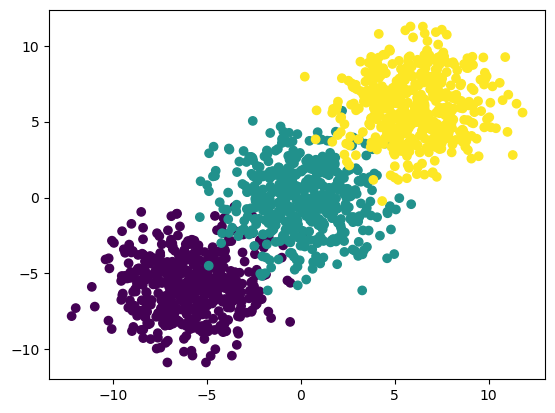

In [45]:
torch.manual_seed(420)

features , labels = tensorGenCla(bias= True, deg_dispersion= [6, 2])
plt.scatter(features[:, 0], features[:, 1], c= labels)

Text(0.5, 1.0, 'Accuracy')

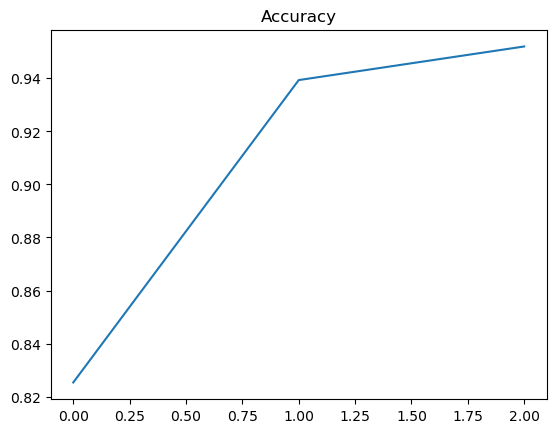

In [51]:
# 设置随机数种子
torch.manual_seed(420)

# 初始化核心参数
batch_size = 10
lr = 0.03
num_epochs = 3
w = torch.randn(3, 3, requires_grad= True, dtype= torch.float32)

# 参与训练的模型方程
net = softmax
loss = m_cross_entropy
train_acc = []

# 模型训练过程
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w), y)
        l.backward()
        sgd(w, lr)
    train_acc.append(m_accracy(net(features, w), labels))

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)
plt.title('Accuracy')

In [52]:
# 查看模型结果
w

tensor([[-0.8345, -0.2962,  0.1486],
        [-0.0644,  0.3925,  0.8223],
        [-0.3370,  1.6281, -0.6391]], requires_grad=True)

* 模型调试

首先，尝试多迭代几轮，观察模型收敛速度

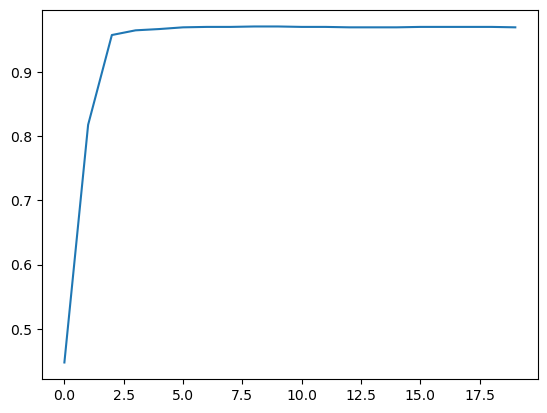

In [54]:
# 设置随机数种子
torch.manual_seed(420)

# 迭代轮数
num_epochs = 20

# 设置初始权重
w = torch.randn(3, 3, requires_grad= True, dtype= torch.float32)

# 设置列表容器
train_acc = []

# 执行迭代
for i in range(num_epochs):
    for epoch in range(i):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w), y)
            l.backward()
            sgd(w, lr)
    train_acc.append(m_accracy(net(features, w), labels))

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)

和此前的逻辑回归实验结果类似，再数据内部离散程度较低的情况下，模型收敛速度较快。当然，这里我们可以进行简单拓展，那就是当每一轮epoch是w都进行不动的随机取值，会不会影响模型的收敛速度。

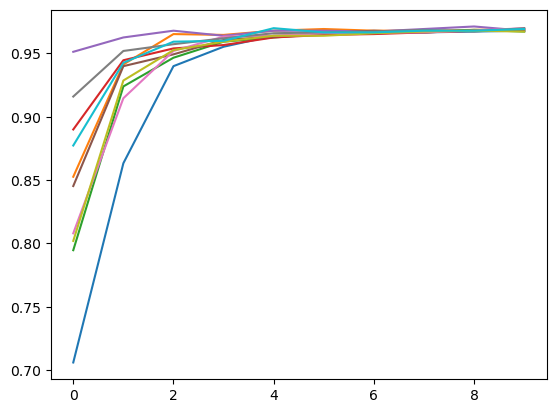

In [55]:
# 取10组不同的w，在叠嗲10轮的情况下观察其收敛速度
for i in range(10):
    w = torch.randn(3, 3, requires_grad= True, dtype= torch.float32)
    train_acc = []
    for epoch in range(10):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w), y)
            l.backward()
            sgd(w, lr)
        train_acc.append(m_accracy(net(features, w), labels))
    plt.plot(list(range(10)), train_acc)

能够发现，尽管初始w的随机取值会影响前期模型的准确率，但在整体收敛速度较快的情况下，基本在5轮左右模型就可以达到较高的准确率。也就是说，损失函数的初始值点各不相同，但通过一轮轮梯度下降算法的迭代，都能够找到最小值点。此处即验证了梯度下降算法本身的有效性，同时也说明对于该数据集来说，找到损失函数的最小值点并不苦难。

## 12.5.2 softmax回归的快速实现

接下来，尝试通过调库快速softmax回归。经过一轮手动实现，我们已经对softmax回归的各种建模细节以及数学运算过程已经非常熟悉，调库也就更加容易。

* 定义核心参数

In [56]:
batch_size = 10 
lr = 0.03
num_epochs = 3


* 数据准备

In [57]:
# 设置随机数种子
torch.manual_seed(420)

# 创建数据集
features, labels = tensorGenCla(deg_dispersion= [6, 2])
labels = labels.float()
data = TensorDataset(features, labels)
batchData = DataLoader(data, batch_size= batch_size, shuffle= True)

In [58]:
features

tensor([[-6.0141, -4.9911],
        [-4.6593, -6.7657],
        [-5.9395, -5.2347],
        ...,
        [ 6.4622,  4.1406],
        [ 5.7278,  9.2208],
        [ 4.9705,  3.1236]])

* Stage 1. 定义模型

In [68]:
class softmaxR(nn.Module):
    def __init__(self, input = 2, output = 3):
        super().__init__()
        self.linear1 = nn.Linear(input, output, bias= True)
    
    def forward(self, X):
        z1 = self.linear1(X)
        return z1

softmax_model = softmaxR()

    由于我们所采用的 CrossEntropyLoss类进行的损失函数求解，该类会自动输入对象进行softmax转化。因此上述过程仍只是构建了模型基本框架

* Stage 2.定义损失函数

In [66]:
criterion = nn.CrossEntropyLoss()


* Stage 3.定义优化算法

In [63]:
optimizer = optim.SGD(softmax_model.parameters(), lr= lr)

* Stage 4.模型训练

In [64]:
def fit(net, criterion, optimizer, batchData, epochs):
    for epoch in range(epochs):
        for X, y in batchData:
            zhat = net.forward(X)
            y = y.flatten().long()
            loss = criterion(zhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

接下来，即可执行模型训练

In [69]:
fit(net= softmax_model,
    criterion= criterion,
    optimizer= optimizer,
    batchData= batchData,
    epochs= num_epochs)

查看模型训练结果

In [70]:
softmax_model

softmaxR(
  (linear1): Linear(in_features=2, out_features=3, bias=True)
)

In [71]:
# 查看模型参数
print(list(softmax_model.parameters()))

[Parameter containing:
tensor([[ 0.3489,  0.0699],
        [-0.0753, -0.0817],
        [ 0.3690, -0.2744]], requires_grad=True), Parameter containing:
tensor([-0.0995, -0.6385, -0.3764], requires_grad=True)]


2. 模型调试

首先，上述结果能否再多迭代几轮的情况下逐步提升

In [73]:
# 设置随机数种子
torch.manual_seed(420)

# 创建数据集
features, labels = tensorGenCla(deg_dispersion= [6, 2])
labels = labels.float()
data = TensorDataset(features, labels)
batchData = DataLoader(data, batch_size= batch_size, shuffle= True)



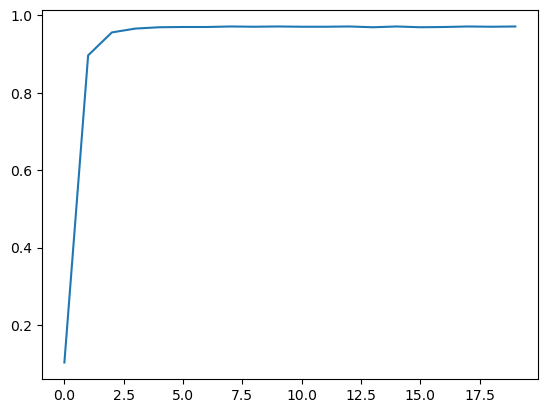

In [75]:
# 设置随机数种子
torch.manual_seed(420)

# 初始化核心参数
num_epochs = 20
SF1 = softmaxR()
cr1 = nn.CrossEntropyLoss()
op1 = optim.SGD(SF1.parameters(), lr= lr)

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(num_epochs):
    fit(net= SF1,
        optimizer= op1,
        criterion= cr1,
        batchData= batchData,
        epochs= epochs)
    epoch_acc = m_accracy(F.softmax(SF1(features), 1), labels)
    train_acc.append(epoch_acc)

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)
    

和手动实现相同，此处模型也展示了非常快的收敛速度。当然需要再次强调，当 num_epochs=20时，SF1参数已经训练了（19+18+...+1）次了

然后再考虑增加数据集分类难度

In [76]:
# 设置随机数种子
torch.manual_seed(420)

# 创建数据集
features, labels = tensorGenCla(deg_dispersion= [6, 4])
labels = labels.float()
data = TensorDataset(features, labels)
batchData = DataLoader(data, batch_size= batch_size, shuffle= True)



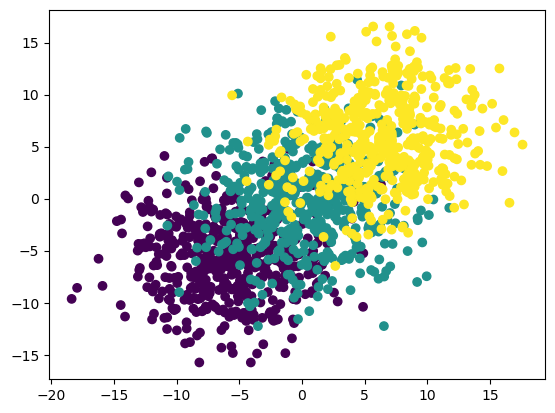

In [77]:
plt.scatter(features[:, 0], features[:, 1], c= labels)

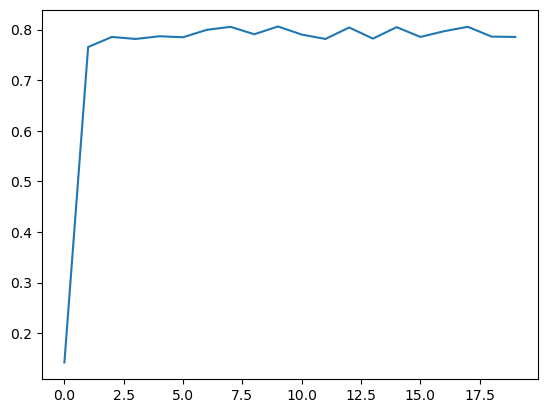

In [78]:
# 设置随机数种子
torch.manual_seed(420)

# 初始化核心参数
num_epochs = 20
SF1 = softmaxR()
cr1 = nn.CrossEntropyLoss()
op1 = optim.SGD(SF1.parameters(), lr= lr)

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(num_epochs):
    fit(net= SF1,
        optimizer= op1,
        criterion= cr1,
        batchData= batchData,
        epochs= epochs)
    epoch_acc = m_accracy(F.softmax(SF1(features), 1), labels)
    train_acc.append(epoch_acc)

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)
    

In [79]:
train_acc

[tensor(0.1420),
 tensor(0.7653),
 tensor(0.7853),
 tensor(0.7813),
 tensor(0.7867),
 tensor(0.7847),
 tensor(0.7993),
 tensor(0.8053),
 tensor(0.7907),
 tensor(0.8060),
 tensor(0.7900),
 tensor(0.7813),
 tensor(0.8040),
 tensor(0.7820),
 tensor(0.8047),
 tensor(0.7853),
 tensor(0.7967),
 tensor(0.8053),
 tensor(0.7860),
 tensor(0.7853)]

我们发现，收敛速度仍然很快，模型很快就达到了比较稳定的状态。但和此前的逻辑回归实验相同，模型结果虽然比较稳定，但受到数据集分类难度提升影响，模型准确率却并不高，基本维持再60% 左右。一般来说，此时就代表了模型抵达判别效力上界，此时模型已经无法有效捕捉数据集中规律。

但到底什么叫做模型判别效力的上界呢？从根本上来说就是模型已经到达了损失函数最小值点，但模型评估指标却无法继续提升。首先，我们可以初始选择多个w来观察损失函数是否已经逼近最小值点而不是落在局部最小值点附近。

In [80]:
# 初始化核心参数
crl = nn.CrossEntropyLoss()

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(10):
    SF1 = softmaxR()
    op1 = optim.SGD(SF1.parameters(), lr= lr)
    fit(net= SF1,
        criterion= crl,
        optimizer= op1,
        batchData= batchData,
        epochs= num_epochs)
    epoch_acc = m_accracy(F.softmax(SF1(features), 1), labels)
    train_acc.append(epoch_acc)

In [81]:
train_acc

[tensor(0.7913),
 tensor(0.7913),
 tensor(0.8033),
 tensor(0.8020),
 tensor(0.7980),
 tensor(0.7960),
 tensor(0.8013),
 tensor(0.8007),
 tensor(0.7927),
 tensor(0.8020)]

初始化不同W发现最终模型的准确率仍然是在80% 左右，也从侧面印证迭代过程没有问题，模型已经到达最小值点。也就是说问题并不是出在损失函数的求解熵，而是出在损失函数的构造熵。此时损失函数哪怕是取得最小值点，也无法进一步提升模型效果。而损失函数的构造和模型的构造直接相关，此时若要进一步提升模型效果，就需要调整模型结构了。